In [1]:
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import operator

In [2]:
filename = "2021-2022_NBA_Player_Stats.csv"
df = pd.read_csv(filename,index_col=0, encoding = "ISO-8859-1",  sep=';')
df.head(9)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
1,Precious Achiuwa,C,22,TOR,48,23,23.1,3.1,7.3,0.423,...,0.579,2.2,4.7,6.9,1.1,0.5,0.6,1.0,2.0,7.5
2,Steven Adams,C,28,MEM,56,55,26.1,2.8,5.0,0.546,...,0.556,4.5,5.1,9.6,3.2,0.9,0.7,1.6,1.9,7.0
3,Bam Adebayo,C,24,MIA,33,33,33.0,7.2,13.6,0.527,...,0.764,2.8,7.4,10.2,3.5,1.5,0.6,2.9,3.2,18.7
4,Santi Aldama,PF,21,MEM,27,0,10.3,1.4,3.6,0.381,...,0.600,0.9,1.5,2.4,0.5,0.1,0.3,0.3,1.0,3.3
5,LaMarcus Aldridge,C,36,BRK,38,11,22.8,5.8,10.5,0.558,...,0.844,1.6,4.2,5.8,0.8,0.3,1.1,1.0,1.7,13.7
6,Nickeil Alexander-Walker,SG,23,TOT,52,19,25.4,4.6,12.2,0.374,...,0.722,0.7,2.5,3.2,2.7,0.8,0.4,1.6,1.7,12.3
6,Nickeil Alexander-Walker,SG,23,NOP,50,19,26.3,4.7,12.6,0.375,...,0.722,0.7,2.6,3.3,2.8,0.8,0.4,1.7,1.8,12.8
6,Nickeil Alexander-Walker,SG,23,UTA,2,0,2.5,0.0,0.5,0.000,...,0.000,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
7,Grayson Allen,SG,26,MIL,49,48,28.0,4.0,9.4,0.425,...,0.857,0.5,2.9,3.4,1.5,0.8,0.3,0.6,1.4,11.5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 734 entries, 1 to 592
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  734 non-null    object 
 1   Pos     734 non-null    object 
 2   Age     734 non-null    int64  
 3   Tm      734 non-null    object 
 4   G       734 non-null    int64  
 5   GS      734 non-null    int64  
 6   MP      734 non-null    float64
 7   FG      734 non-null    float64
 8   FGA     734 non-null    float64
 9   FG%     734 non-null    float64
 10  3P      734 non-null    float64
 11  3PA     734 non-null    float64
 12  3P%     734 non-null    float64
 13  2P      734 non-null    float64
 14  2PA     734 non-null    float64
 15  2P%     734 non-null    float64
 16  eFG%    734 non-null    float64
 17  FT      734 non-null    float64
 18  FTA     734 non-null    float64
 19  FT%     734 non-null    float64
 20  ORB     734 non-null    float64
 21  DRB     734 non-null    float64
 22  TR

In [4]:
df.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,...,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,26.044959,28.279292,12.915531,18.114169,2.855586,6.401907,0.420251,0.868801,2.572071,0.274554,...,0.633832,0.810899,2.540736,3.349455,1.775749,0.576158,0.361717,0.979428,1.539782,7.727520
std,4.092637,19.514704,18.423425,9.995226,2.288435,4.781059,0.161695,0.879551,2.292469,0.175847,...,0.305932,0.760459,1.870797,2.438201,1.841861,0.447355,0.392693,0.834717,0.844562,6.265428
min,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,6.250000,0.000000,9.725000,1.100000,2.800000,0.375000,0.100000,0.700000,0.182000,...,0.563000,0.300000,1.225000,1.600000,0.500000,0.300000,0.100000,0.400000,1.000000,3.000000
50%,25.000000,31.000000,3.000000,17.000000,2.400000,5.100000,0.436000,0.600000,2.000000,0.320000,...,0.748000,0.600000,2.300000,2.950000,1.100000,0.500000,0.300000,0.800000,1.600000,6.300000
75%,29.000000,46.000000,20.000000,26.475000,4.000000,8.900000,0.497250,1.400000,3.900000,0.375000,...,0.833000,1.100000,3.400000,4.500000,2.300000,0.800000,0.500000,1.300000,2.200000,10.675000
max,41.000000,60.000000,60.000000,39.000000,11.000000,21.400000,1.000000,4.600000,12.300000,1.000000,...,1.000000,4.500000,11.300000,14.800000,11.000000,2.300000,3.000000,4.800000,4.000000,29.400000


In [5]:
df.loc[df["Player"] == "Nikola Joki?", "Player"] = 'Nikola Jokic'
df.loc[df["Player"] == "Luka Don?i?", "Player"] = 'Luka Doncic'

In [6]:
all_star = [0]*734

In [7]:
df['ALLSTAR'] = all_star

In [8]:
df.loc[df['Player'].isin(['Trae Young', 'DeMar DeRozan', 'Joel Embiid', 'Kevin Durant', 'Giannis Antetokounmpo', 'LaMelo Ball', 
'Darius Garland', 'James Harden', 'Zach LaVine', 'Fred VanVleet', 'Jimmy Butler', 'Khris Middleton', 'Jayson Tatum', 'Jarrett Allen',
'Stephen Curry', 'Ja Morant', 'Nikola Jokic', 'LeBron James', 'Andrew Wiggins', 'Devin Booker', 'Luka Doncic', 'Donovan Mitchell', 
'Dejounte Murray', 'Chris Paul', 'Draymond Green', 'Rudy Gobert', 'Karl-Anthony Towns']), "ALLSTAR"] = 1

In [9]:
df[df['Player'].isin(['Trae Young', 'DeMar DeRozan', 'Joel Embiid', 'Kevin Durant', 'Giannis Antetokounmpo', 'LaMelo Ball', 
'Darius Garland', 'James Harden', 'Zach LaVine', 'Fred VanVleet', 'Jimmy Butler', 'Khris Middleton', 'Jayson Tatum', 'Jarrett Allen',
'Stephen Curry', 'Ja Morant', 'Nikola Jokic', 'LeBron James', 'Andrew Wiggins', 'Devin Booker', 'Luka Doncic', 'Donovan Mitchell', 
'Dejounte Murray', 'Chris Paul', 'Draymond Green', 'Rudy Gobert', 'Karl-Anthony Towns'])]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
8,Jarrett Allen,C,23,CLE,50,50,32.6,6.6,9.9,0.666,...,3.6,7.4,11.0,1.8,0.7,1.3,1.8,1.8,16.2,1
12,Giannis Antetokounmpo,PF,27,MIL,48,48,32.6,10.1,18.4,0.547,...,1.9,9.4,11.3,6.0,0.9,1.4,3.3,3.2,29.4,1
24,LaMelo Ball,PG,20,CHO,52,52,32.6,7.2,16.9,0.425,...,1.6,5.4,7.0,7.4,1.6,0.4,3.1,3.2,20.2,1
58,Devin Booker,SG,25,PHO,51,51,34.1,9.3,20.8,0.446,...,0.8,4.4,5.2,4.5,1.0,0.4,2.4,2.5,25.5,1
86,Jimmy Butler,SF,32,MIA,39,39,33.9,7.2,14.7,0.490,...,1.9,4.4,6.3,5.9,1.8,0.4,2.1,1.5,21.9,1
124,Stephen Curry,PG,33,GSW,54,54,34.8,8.4,19.6,0.427,...,0.6,4.7,5.3,6.3,1.4,0.4,3.2,2.1,25.8,1
132,DeMar DeRozan,PF,32,CHI,55,55,35.6,10.3,19.9,0.517,...,0.8,4.4,5.2,5.1,0.9,0.3,2.3,2.2,28.1,1
139,Luka Doncic,PG,22,DAL,43,43,35.4,9.6,21.3,0.448,...,0.9,8.2,9.0,9.0,1.2,0.5,4.4,2.4,27.0,1
151,Kevin Durant,PF,33,BRK,36,36,36.5,10.5,20.3,0.520,...,0.6,6.9,7.4,5.8,0.8,0.9,3.0,1.9,29.3,1


In [10]:
df[df['Player'].isin(['Klay Thompson'])]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
526,Klay Thompson,SG,31,GSW,16,16,25.3,6.2,14.8,0.418,...,0.4,3.4,3.8,3.1,0.6,0.4,1.4,1.5,17.1,0


In [11]:
dups=df.duplicated()
print(df[dups])

Empty DataFrame
Columns: [Player, Pos, Age, Tm, G, GS, MP, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, eFG%, FT, FTA, FT%, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS, ALLSTAR]
Index: []

[0 rows x 30 columns]


In [12]:
tradedPlayers = df[df.duplicated(['Player'])]
print(tradedPlayers)

                       Player Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  \
Rk                                                                            
6    Nickeil Alexander-Walker  SG   23  NOP  50  19  26.3  4.7  12.6  0.375   
6    Nickeil Alexander-Walker  SG   23  UTA   2   0   2.5  0.0   0.5  0.000   
10            Justin Anderson  SF   28  CLE   3   0  15.7  1.3   2.7  0.500   
10            Justin Anderson  SF   28  IND   3   0  10.0  0.7   3.7  0.182   
23          Marvin Bagley III  PF   22  SAC  30  17  21.9  3.8   8.2  0.463   
..                        ...  ..  ...  ...  ..  ..   ...  ...   ...    ...   
566             Derrick White  SG   27  BOS   4   1  30.3  4.3  11.3  0.378   
581           Justise Winslow  SF   25  LAC  37   1  12.9  1.7   3.8  0.447   
581           Justise Winslow  SF   25  POR   6   5  31.3  4.8  10.5  0.460   
588            Thaddeus Young  PF   33  SAS  26   1  14.2  2.8   4.9  0.578   
588            Thaddeus Young  PF   33  TOR   2   0 

In [13]:
tradedPlayers[tradedPlayers['Player'] == 'Nickeil Alexander-Walker']

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
6,Nickeil Alexander-Walker,SG,23,NOP,50,19,26.3,4.7,12.6,0.375,...,0.7,2.6,3.3,2.8,0.8,0.4,1.7,1.8,12.8,0
6,Nickeil Alexander-Walker,SG,23,UTA,2,0,2.5,0.0,0.5,0.000,...,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
df[df['Player'] == 'Nickeil Alexander-Walker']

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
6,Nickeil Alexander-Walker,SG,23,TOT,52,19,25.4,4.6,12.2,0.374,...,0.7,2.5,3.2,2.7,0.8,0.4,1.6,1.7,12.3,0
6,Nickeil Alexander-Walker,SG,23,NOP,50,19,26.3,4.7,12.6,0.375,...,0.7,2.6,3.3,2.8,0.8,0.4,1.7,1.8,12.8,0
6,Nickeil Alexander-Walker,SG,23,UTA,2,0,2.5,0.0,0.5,0.000,...,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0


In [15]:
df[df['Tm'] == 'TOT']

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
6,Nickeil Alexander-Walker,SG,23,TOT,52,19,25.4,4.6,12.2,0.374,...,0.7,2.5,3.2,2.7,0.8,0.4,1.6,1.7,12.3,0
10,Justin Anderson,SF,28,TOT,6,0,12.8,1.0,3.2,0.316,...,0.3,1.3,1.7,1.5,0.3,0.2,0.5,1.5,3.5,0
23,Marvin Bagley III,PF,22,TOT,32,17,21.9,3.8,8.2,0.460,...,2.3,4.9,7.2,0.6,0.3,0.3,0.7,1.6,9.2,0
44,D?vis Bert?ns,PF,29,TOT,35,0,14.7,1.8,5.1,0.358,...,0.2,1.6,1.8,0.5,0.3,0.2,0.4,1.6,5.9,0
72,Charlie Brown Jr.,SG,24,TOT,19,2,9.1,0.5,2.1,0.256,...,0.7,0.9,1.7,0.3,0.5,0.2,0.3,0.9,1.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,Brad Wanamaker,PG,32,TOT,23,2,13.9,1.2,3.3,0.364,...,0.3,1.4,1.7,2.4,0.3,0.3,1.0,2.0,3.6,0
560,Tremont Waters,PG,24,TOT,3,0,16.7,1.3,4.7,0.286,...,0.0,1.3,1.3,2.3,1.7,0.0,1.3,1.3,3.3,0
566,Derrick White,SG,27,TOT,53,49,30.3,4.9,11.6,0.423,...,0.5,3.0,3.6,5.5,1.1,0.9,1.8,2.4,14.2,0


In [16]:
df = df.drop_duplicates(subset=['Player'])
df[df['Tm'] == 'TOT']

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
6,Nickeil Alexander-Walker,SG,23,TOT,52,19,25.4,4.6,12.2,0.374,...,0.7,2.5,3.2,2.7,0.8,0.4,1.6,1.7,12.3,0
10,Justin Anderson,SF,28,TOT,6,0,12.8,1.0,3.2,0.316,...,0.3,1.3,1.7,1.5,0.3,0.2,0.5,1.5,3.5,0
23,Marvin Bagley III,PF,22,TOT,32,17,21.9,3.8,8.2,0.460,...,2.3,4.9,7.2,0.6,0.3,0.3,0.7,1.6,9.2,0
44,D?vis Bert?ns,PF,29,TOT,35,0,14.7,1.8,5.1,0.358,...,0.2,1.6,1.8,0.5,0.3,0.2,0.4,1.6,5.9,0
72,Charlie Brown Jr.,SG,24,TOT,19,2,9.1,0.5,2.1,0.256,...,0.7,0.9,1.7,0.3,0.5,0.2,0.3,0.9,1.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,Brad Wanamaker,PG,32,TOT,23,2,13.9,1.2,3.3,0.364,...,0.3,1.4,1.7,2.4,0.3,0.3,1.0,2.0,3.6,0
560,Tremont Waters,PG,24,TOT,3,0,16.7,1.3,4.7,0.286,...,0.0,1.3,1.3,2.3,1.7,0.0,1.3,1.3,3.3,0
566,Derrick White,SG,27,TOT,53,49,30.3,4.9,11.6,0.423,...,0.5,3.0,3.6,5.5,1.1,0.9,1.8,2.4,14.2,0


In [17]:
df[df['G']<10]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
10,Justin Anderson,SF,28,TOT,6,0,12.8,1.0,3.2,0.316,...,0.3,1.3,1.7,1.5,0.3,0.2,0.5,1.5,3.5,0
20,Joel Ayayi,SG,21,WAS,7,0,2.9,0.1,0.9,0.167,...,0.1,0.3,0.4,0.6,0.0,0.0,0.0,0.0,0.3,0
29,Cat Barber,PG,27,ATL,3,0,4.3,0.0,1.3,0.000,...,0.3,0.7,1.0,1.0,0.0,0.0,0.3,0.3,0.0,0
34,Paris Bass,SF,26,PHO,2,0,3.5,1.0,3.0,0.333,...,1.0,1.0,2.0,0.0,0.5,0.0,1.0,1.0,3.0,0
42,Jordan Bell,C,27,CHI,1,0,2.0,0.0,0.0,0.000,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,Patrick Williams,PF,20,CHI,5,5,25.0,2.6,4.6,0.565,...,0.2,2.0,2.2,0.6,0.6,0.4,0.4,1.8,6.6,0
579,D.J. Wilson,PF,25,TOR,3,1,16.0,2.7,3.7,0.727,...,0.3,4.3,4.7,1.3,1.7,0.3,0.7,1.7,8.0,0
582,Cassius Winston,PG,23,WAS,4,0,5.8,0.8,1.5,0.500,...,0.0,0.0,0.0,1.0,0.0,0.0,0.3,1.0,2.5,0


In [18]:
df = df.drop(df[df['G'] < 10].index)

In [19]:
df.describe

<bound method NDFrame.describe of                 Player Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  ...  \
Rk                                                                    ...   
1     Precious Achiuwa   C   22  TOR  48  23  23.1  3.1   7.3  0.423  ...   
2         Steven Adams   C   28  MEM  56  55  26.1  2.8   5.0  0.546  ...   
3          Bam Adebayo   C   24  MIA  33  33  33.0  7.2  13.6  0.527  ...   
4         Santi Aldama  PF   21  MEM  27   0  10.3  1.4   3.6  0.381  ...   
5    LaMarcus Aldridge   C   36  BRK  38  11  22.8  5.8  10.5  0.558  ...   
..                 ...  ..  ...  ...  ..  ..   ...  ...   ...    ...  ...   
588     Thaddeus Young  PF   33  TOT  28   1  14.4  2.9   5.1  0.570  ...   
589         Trae Young  PG   23  ATL  53  53  34.4  9.3  20.5  0.456  ...   
590     Omer Yurtseven   C   23  MIA  41  10  14.1  2.6   4.9  0.530  ...   
591        Cody Zeller   C   29  POR  27   0  13.1  1.9   3.3  0.567  ...   
592        Ivica Zubac   C   24  LAC  54  

In [20]:
print("Dataset obsahuje celkovo %d chýbajúcich hodnôt"%int(df.shape[0] - df.dropna().shape[0]))

Dataset obsahuje celkovo 0 chýbajúcich hodnôt


In [21]:
df.corr()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Age,1.000000,0.085116,0.099454,0.180484,0.112227,0.097998,0.076155,0.142276,0.117315,0.122764,...,0.030621,0.155821,0.129804,0.181265,0.120900,0.045808,0.105365,0.128670,0.120894,0.084418
G,0.085116,1.000000,0.593106,0.629706,0.494640,0.484588,0.198132,0.436344,0.434085,0.206731,...,0.214315,0.461798,0.421698,0.370420,0.468641,0.245118,0.387364,0.440495,0.494565,0.167006
GS,0.099454,0.593106,1.000000,0.831614,0.749917,0.724178,0.214993,0.504954,0.507279,0.105894,...,0.357868,0.676913,0.632193,0.599345,0.591010,0.403595,0.663923,0.601930,0.741986,0.365155
MP,0.180484,0.629706,0.831614,1.000000,0.884002,0.885974,0.162531,0.685303,0.697849,0.211427,...,0.280452,0.712740,0.634504,0.716476,0.729920,0.373872,0.768653,0.686716,0.884750,0.358338
FG,0.112227,0.494640,0.749917,0.884002,1.000000,0.973228,0.234144,0.629851,0.646157,0.186111,...,0.293563,0.725863,0.648103,0.724416,0.609178,0.360536,0.838743,0.599452,0.990812,0.519475
FGA,0.097998,0.484588,0.724178,0.885974,0.973228,1.000000,0.050291,0.737989,0.768510,0.231649,...,0.145389,0.641764,0.536783,0.754659,0.628949,0.249233,0.845503,0.548881,0.981274,0.477847
FG%,0.076155,0.198132,0.214993,0.162531,0.234144,0.050291,1.000000,-0.237379,-0.289322,-0.172926,...,0.592838,0.392402,0.488455,-0.012599,0.049597,0.483146,0.108635,0.367693,0.174749,0.117627
3P,0.142276,0.436344,0.504954,0.685303,0.629851,0.737989,-0.237379,1.000000,0.983515,0.427313,...,-0.264222,0.258552,0.114274,0.513671,0.477670,-0.061021,0.512998,0.278927,0.684289,0.270688
3PA,0.117315,0.434085,0.507279,0.697849,0.646157,0.768510,-0.289322,0.983515,1.000000,0.379248,...,-0.269721,0.272327,0.122800,0.545795,0.499603,-0.051338,0.550811,0.293753,0.701291,0.267647
3P%,0.122764,0.206731,0.105894,0.211427,0.186111,0.231649,-0.172926,0.427313,0.379248,1.000000,...,-0.244259,-0.030245,-0.099273,0.151611,0.109966,-0.179761,0.116348,0.022967,0.210191,0.037813


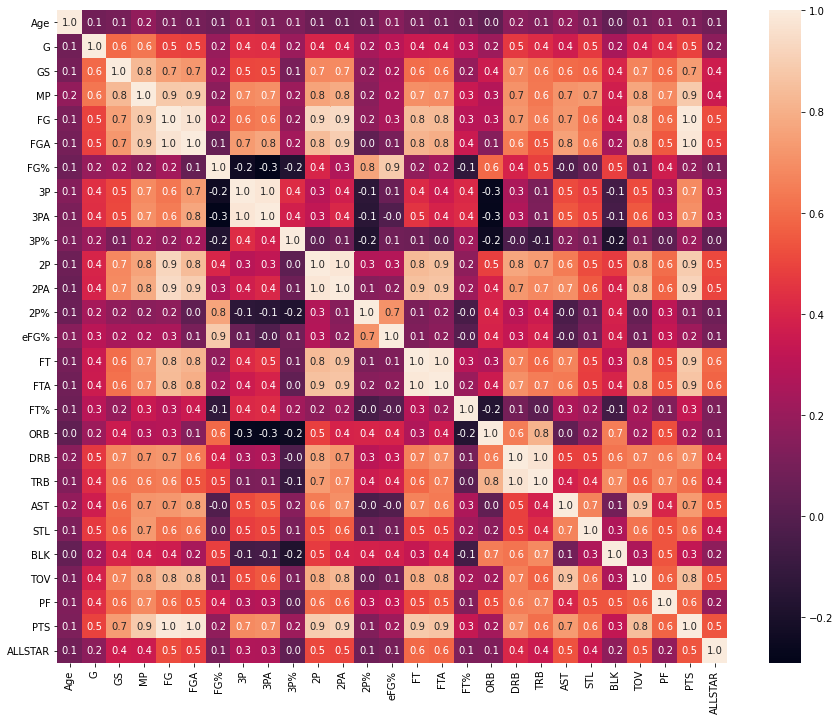

In [22]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(df.corr(), ax=ax, annot=True, fmt=".1f")

In [16]:
#sns.pairplot(df,hue="ALLSTAR")

Subsets

In [23]:
not_AS = df[df['ALLSTAR'] == 0]
a_stars = df[df['ALLSTAR'] == 1]

In [24]:
def iqr(attribute): 
    return df[attribute].quantile(0.75) - df[attribute].quantile(0.25) 

def outliers(attribute):
    iqrange = iqr(attribute)
    lower_bound = df[attribute].quantile(0.25) -(1.5 * iqrange)
    upper_bound = df[attribute].quantile(0.75) +(1.5 * iqrange)
    return df[(df[attribute] > upper_bound) | (df[attribute] < lower_bound)]

In [25]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

Age

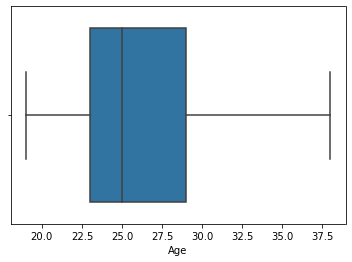

In [26]:
sns.boxplot('Age', data=df)

In [27]:
print("Number of outliers for age is: ",len(outliers('Age')))

Number of outliers for age is:  0


In [28]:
df['Age'].describe()

count    469.000000
mean      25.948827
std        4.274945
min       19.000000
25%       23.000000
50%       25.000000
75%       29.000000
max       38.000000
Name: Age, dtype: float64

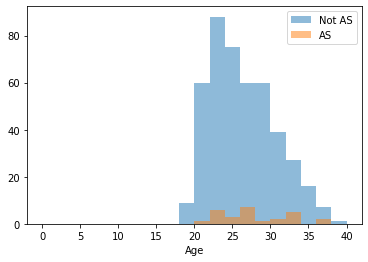

In [29]:
bins = np.arange(0, 42, 2)

plt.hist(not_AS['Age'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['Age'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Age')
plt.show()

(0.0, 45.0)

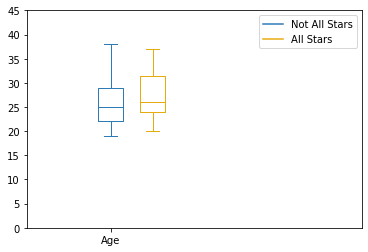

In [30]:
plt.figure()

ticks = ["Age"]

bpna = plt.boxplot(not_AS['Age'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['Age'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0, 45)

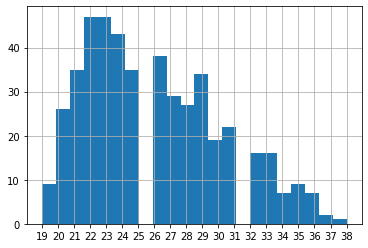

In [31]:
plt.xticks(np.arange(18, 42, 1))
plt.yticks(np.arange(0, 100, 10))
df['Age'].hist(bins=22)

In [32]:
stats.shapiro(df.Age)

ShapiroResult(statistic=0.956838846206665, pvalue=1.7513986094730427e-10)

Games

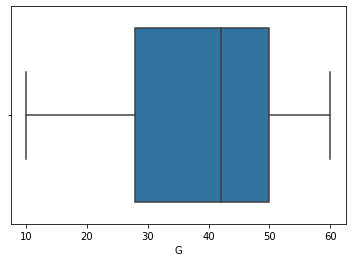

In [33]:
sns.boxplot('G', data=df)

In [34]:
print("Number of outliers for games played is: ",len(outliers('G')))

Number of outliers for games played is:  0


In [35]:
df['G'].describe()

count    469.000000
mean      38.929638
std       13.437786
min       10.000000
25%       28.000000
50%       42.000000
75%       50.000000
max       60.000000
Name: G, dtype: float64

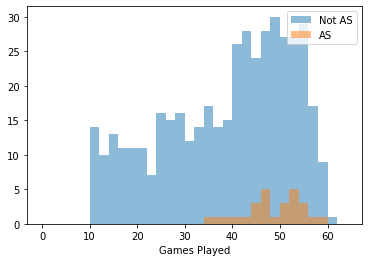

In [36]:
bins = np.arange(0, 66, 2)

plt.hist(not_AS['G'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['G'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Games Played')
plt.savefig('G-hist.png')
plt.show()

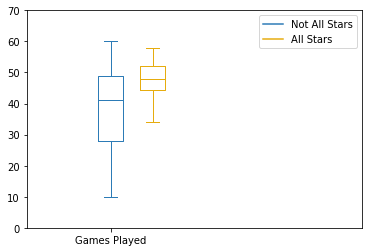

In [37]:
plt.figure()

ticks = ["Games Played"]

bpna = plt.boxplot(not_AS['G'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['G'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0, 70)
plt.savefig('G-box.png')

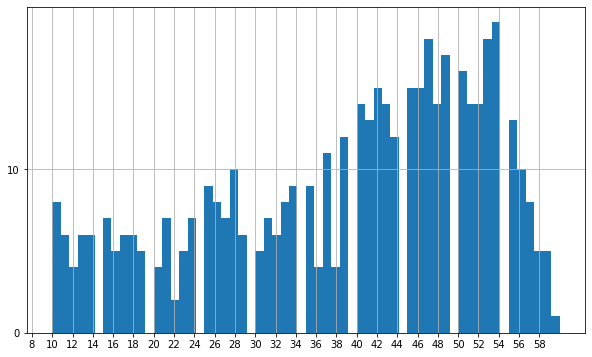

In [38]:
plt.xticks(np.arange(0, 60, 2))
plt.yticks(np.arange(0, 100, 10))
df['G'].hist(bins=60, figsize=(10, 6))

In [39]:
stats.shapiro(df.G)

ShapiroResult(statistic=0.9344107508659363, pvalue=1.697257785704398e-13)

Minutes

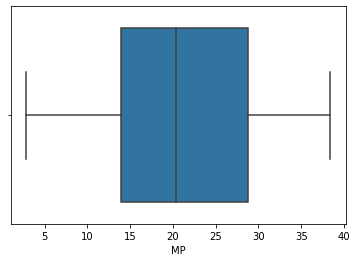

In [40]:
sns.boxplot('MP', data=df)

In [41]:
print("Number of outliers for minutes played is: ",len(outliers('MP')))

Number of outliers for minutes played is:  0


In [42]:
df['MP'].describe()

count    469.000000
mean      21.002132
std        9.020596
min        2.800000
25%       13.900000
50%       20.300000
75%       28.800000
max       38.400000
Name: MP, dtype: float64

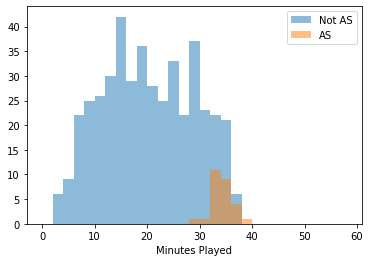

In [43]:
bins = np.arange(0, 60, 2)

plt.hist(not_AS['MP'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['MP'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Minutes Played')
plt.savefig('MP-hist.png')
plt.show()


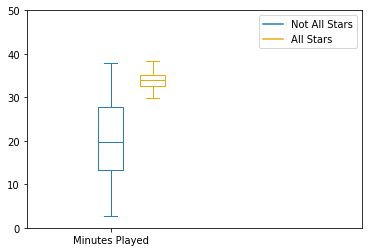

In [44]:
plt.figure()

ticks = ["Minutes Played"]

bpna = plt.boxplot(not_AS['MP'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['MP'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0, 50)
plt.savefig('MP-box.png')

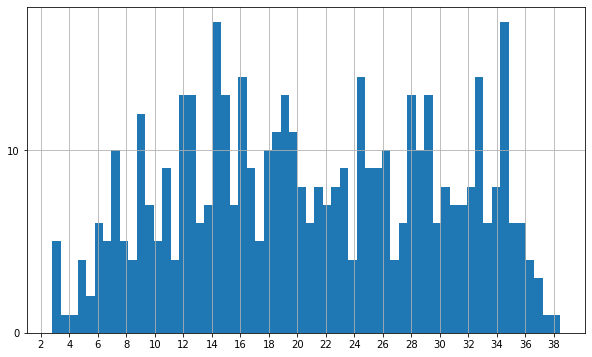

In [45]:
plt.xticks(np.arange(0, 40, 2))
plt.yticks(np.arange(0, 40, 10))
df['MP'].hist(bins=60, figsize=(10, 6))

In [46]:
stats.shapiro(df.MP)

ShapiroResult(statistic=0.9664855003356934, pvalue=7.207547447762863e-09)

Points per game

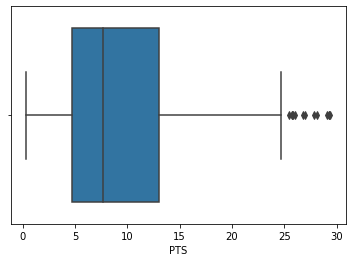

In [47]:
sns.boxplot('PTS', data=df)

In [48]:
print("Number of outliers for points scored is: ",len(outliers('PTS')))

Number of outliers for points scored is:  13


In [49]:
df['PTS'].describe()

count    469.000000
mean       9.355224
std        6.276622
min        0.300000
25%        4.700000
50%        7.700000
75%       13.000000
max       29.400000
Name: PTS, dtype: float64

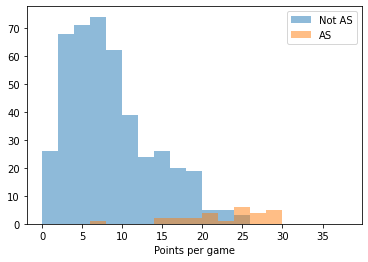

In [50]:
bins = np.arange(0, 40, 2)

plt.hist(not_AS['PTS'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['PTS'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Points per game')
plt.savefig('PTS-hist.png')
plt.show()

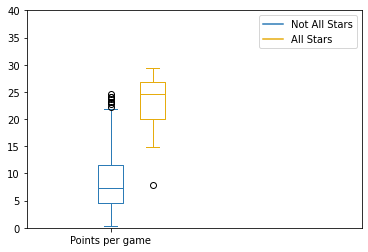

In [51]:
plt.figure()

ticks = ["Points per game"]

bpna = plt.boxplot(not_AS['PTS'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['PTS'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0, 40)
plt.savefig('PTS-box.png')

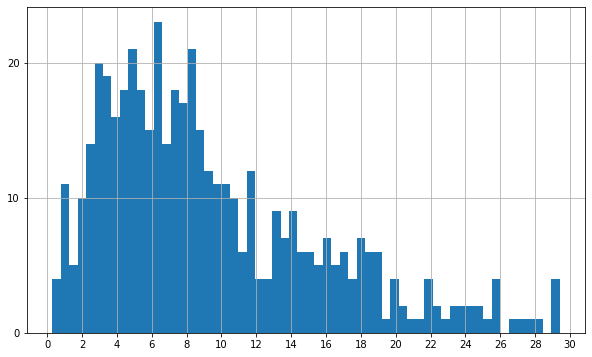

In [52]:
plt.xticks(np.arange(0, 35, 2))
plt.yticks(np.arange(0, 40, 10))
df['PTS'].hist(bins=60, figsize=(10, 6))

In [53]:
stats.shapiro(df.PTS)

ShapiroResult(statistic=0.9151745438575745, pvalue=1.461080270883004e-15)

Shooting efficiency eFG%

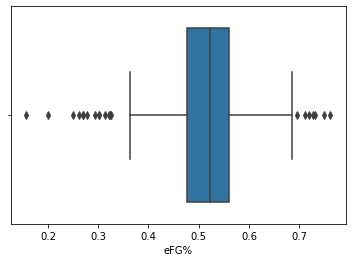

In [54]:
sns.boxplot('eFG%', data=df)

In [55]:
print("Number of outliers for shooting efficiency is: ",len(outliers('eFG%')))

Number of outliers for shooting efficiency is:  21


In [56]:
df['eFG%'].describe()

count    469.000000
mean       0.517868
std        0.078641
min        0.156000
25%        0.476000
50%        0.522000
75%        0.561000
max        0.762000
Name: eFG%, dtype: float64

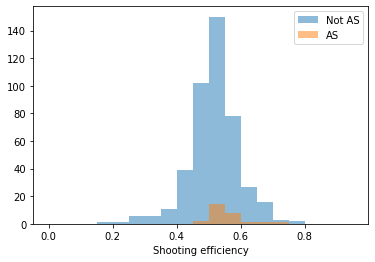

In [57]:
bins = np.arange(0.0, 1.0, 0.05)

plt.hist(not_AS['eFG%'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['eFG%'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Shooting efficiency')
plt.show()

(0.0, 1.5)

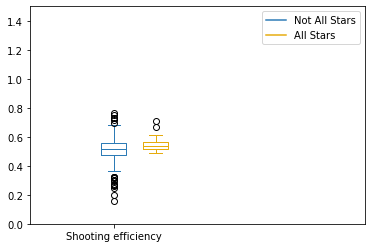

In [58]:
plt.figure()

ticks = ["Shooting efficiency"]

bpna = plt.boxplot(not_AS['eFG%'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['eFG%'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0., 1.5)

Predicting Points per games

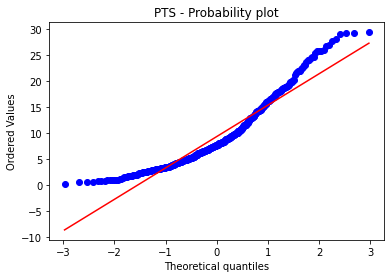

In [59]:
stats.probplot(df['PTS'], dist="norm", plot=pylab)
plt.title('PTS - Probability plot')
plt.savefig('PTS-qq.png')
pylab.show()

In [60]:
pts_shapiro = stats.shapiro(df.PTS)
tov_shapiro = stats.shapiro(df.TOV)
stl_shapiro = stats.shapiro(df.STL)
pf_shapiro = stats.shapiro(df.PF)
mp_shapiro = stats.shapiro(df.MP)
ft_shapiro = stats.shapiro(df.FT)

print("Shapiro PTS: Statistics: ", pts_shapiro.statistic , " P-values", format( pts_shapiro.pvalue, '.28f'))
print("Shapiro TOV: Statistics: ", tov_shapiro.statistic , " P-values", format( tov_shapiro.pvalue, '.28f'))
print("Shapiro STL: Statistics: ", stl_shapiro.statistic , " P-values", format( stl_shapiro.pvalue, '.28f'))
print("Shapiro PF: Statistics: ", pf_shapiro.statistic , " P-values", format( pf_shapiro.pvalue, '.28f'))
print("Shapiro MP: Statistics: ", mp_shapiro.statistic , " P-values", format( mp_shapiro.pvalue, '.28f'))
print("Shapiro FT: Statistics: ", ft_shapiro.statistic , " P-values", format( ft_shapiro.pvalue, '.28f'))


Shapiro PTS: Statistics:  0.9151745438575745  P-values 0.0000000000000014610802708830
Shapiro TOV: Statistics:  0.8657345771789551  P-values 0.0000000000000000001182280590
Shapiro STL: Statistics:  0.9523859620094299  P-values 0.0000000000375619882420075157
Shapiro PF: Statistics:  0.9922371506690979  P-values 0.0152853261679410934448242188
Shapiro MP: Statistics:  0.9664855003356934  P-values 0.0000000072075474477628631575
Shapiro FT: Statistics:  0.7926532626152039  P-values 0.0000000000000000000000052660


In [61]:
def powerpuffgirls(data, method):
    power = PowerTransformer(method=method, standardize=True) 
    data_trans = power.fit_transform(data.copy())
    return data_trans

def best_transform(column,data):
    pvalues=dict()

    pvalues['data']=[stats.shapiro(data[column])[1],data]
       
    data_y=data.copy()
    data_y[column]=powerpuffgirls(data_y[[column]],"yeo-johnson")
    pvalues['data_y']=[stats.shapiro( data_y[column])[1],data_y]
    
    
    if (any(data[column]<=0)==False):
        data_b=data.copy()
        data_b[column]=powerpuffgirls(data_b[[column]],"box-cox")
        pvalues['data_b']=[stats.shapiro( data_b[column])[1],data_b]
    
    sorted_pvalues=sorted(pvalues.items(),key=operator.itemgetter(0))
    
    return(sorted_pvalues[-1][1][1])


In [62]:
col_list = ['PTS', 'AST', 'TOV', 'FT', 'MP', 'STL','PF']

for col in col_list:
  print('------------')
  print(col)
  transformed = best_transform(col, df)
  t_shapiro = stats.shapiro(transformed[col])
  print("Shapiro ", col, " : Statistics: ", t_shapiro.statistic , " P-values", format( t_shapiro.pvalue, '.28f'))
  

  


------------
PTS
Shapiro  PTS  : Statistics:  0.9928681254386902  P-values 0.0250318050384521484375000000
------------
AST
Shapiro  AST  : Statistics:  0.9838979244232178  P-values 0.0000458833019365556538105011
------------
TOV
Shapiro  TOV  : Statistics:  0.9888810515403748  P-values 0.0012480051955208182334899902
------------
FT
Shapiro  FT  : Statistics:  0.987836480140686  P-values 0.0005996549734845757484436035
------------
MP
Shapiro  MP  : Statistics:  0.9681586623191833  P-values 0.0000000146447227677981572924
------------
STL
Shapiro  STL  : Statistics:  0.987789511680603  P-values 0.0005805197870358824729919434
------------
PF
Shapiro  PF  : Statistics:  0.9930816292762756  P-values 0.0296091828495264053344726562


Personal fouls

Pearson correlation: 0.581


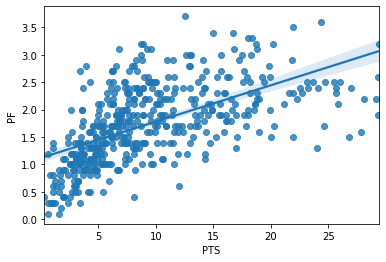

In [63]:
sns.regplot(x="PTS", y="PF", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['PF']))

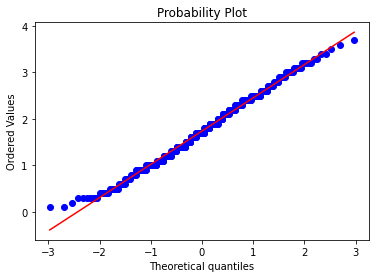

In [64]:
stats.probplot(df['PF'], dist="norm", plot=pylab)
pylab.show()

Turn overs

Pearson correlation: 0.847


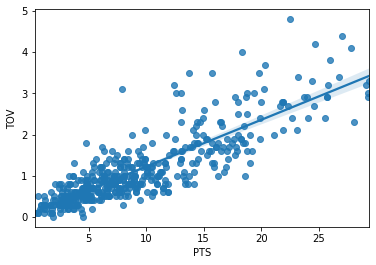

In [65]:
sns.regplot(x="PTS", y="TOV", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['TOV']))
plt.savefig('PTS-TOV-corr.png')

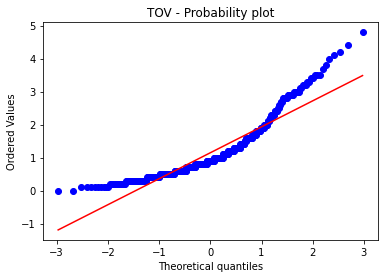

In [66]:
stats.probplot(df['TOV'], dist="norm", plot=pylab)
plt.title('TOV - Probability plot')
plt.savefig('TOV-qq.png')
pylab.show()

Pearson correlation: 0.885


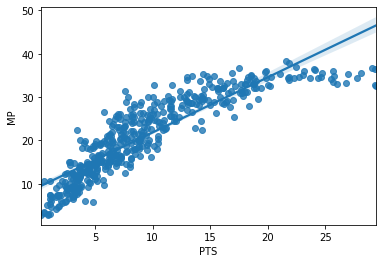

In [67]:
sns.regplot(x="PTS", y="MP", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['MP']))
plt.savefig('PTS-MP-corr.png')

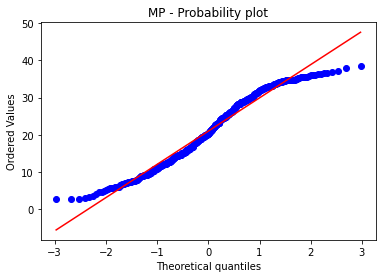

In [68]:
stats.probplot(df['MP'], dist="norm", plot=pylab)
plt.title('MP - Probability plot')
plt.savefig('MP-qq.png')
pylab.show()

Free throws made

Pearson correlation: 0.881


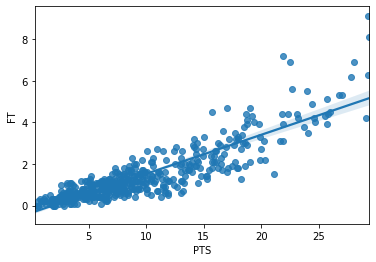

In [69]:
sns.regplot(x="PTS", y="FT", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['FT']))
plt.savefig('PTS-FT-corr.png')

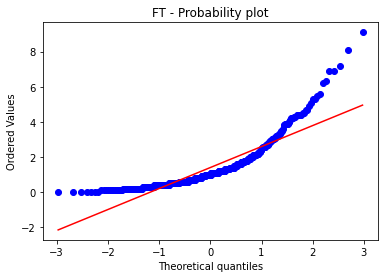

In [70]:
stats.probplot(df['FT'], dist="norm", plot=pylab)
plt.title('FT - Probability plot')
plt.savefig('FT-qq.png')
pylab.show()

Steals

Pearson correlation: 0.611


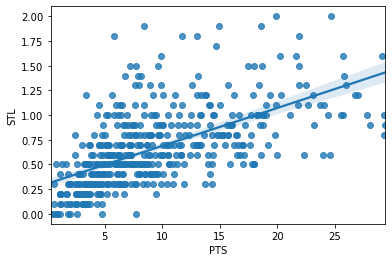

In [71]:
sns.regplot(x="PTS", y="STL", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['STL']))

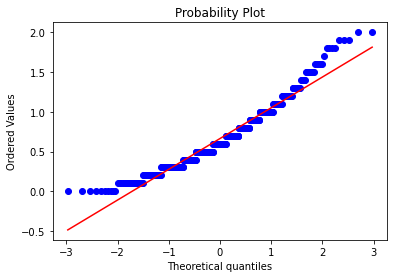

In [72]:
stats.probplot(df['STL'], dist="norm", plot=pylab)
pylab.show()

Assists

Pearson correlation: 0.737


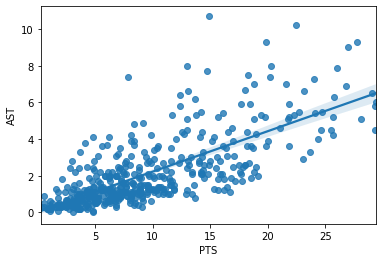

In [73]:
sns.regplot(x="PTS", y="AST", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['AST']))
plt.savefig('PTS-AST-corr.png')

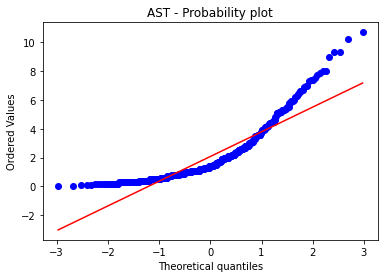

In [74]:
stats.probplot(df['AST'], dist="norm", plot=pylab)
plt.title('AST - Probability plot')
plt.savefig('AST-qq.png')
pylab.show()

In [75]:
data = df[['PTS', 'AST', 'TOV', 'FT', 'MP']]
data.head(9)

,PTS,AST,TOV,FT,MP
Rk,,,,,
1,7.5,1.1,1.0,0.9,23.1
2,7.0,3.2,1.6,1.5,26.1
3,18.7,3.5,2.9,4.4,33.0
4,3.3,0.5,0.3,0.4,10.3
5,13.7,0.8,1.0,1.7,22.8
6,12.3,2.7,1.6,1.3,25.4
7,11.5,1.5,0.6,1.0,28.0
8,16.2,1.8,1.8,3.0,32.6
9,5.1,2.0,0.5,0.6,12.8


All

In [238]:
X_train, X_test, y_train, y_test = train_test_split(data[['AST', 'TOV', 'FT', 'MP']], data['PTS'], test_size=0.2, random_state=42)

In [239]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [240]:
predictedPoints = regr.predict(X_test)

In [241]:
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, predictedPoints))
print('RMSE:',poly_reg_rmse)
print('MSE:',mean_squared_error(y_test, predictedPoints))

RMSE: 1.5831205534650283
MSE: 2.506270686803418


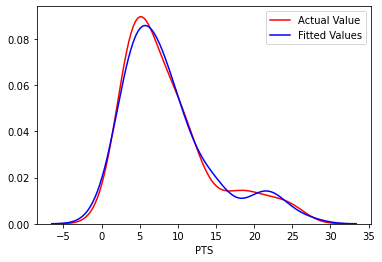

In [84]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(predictedPoints, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [86]:
np.amin(y_test)

0.6

In [85]:
np.amin(predictedPoints)

-0.16698913979424646

In [87]:
(predictedPoints<0).sum()

1

In [88]:
df['PTS'].describe()

count    469.000000
mean       9.355224
std        6.276622
min        0.300000
25%        4.700000
50%        7.700000
75%       13.000000
max       29.400000
Name: PTS, dtype: float64

polynomial

In [234]:
X, y = data[['AST', 'TOV', 'FT', 'MP']], data['PTS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
poly_reg = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = linear_model.LinearRegression()
pol_reg.fit(X_poly, y_train)

LinearRegression()

In [235]:
poly_all_pred = pol_reg.predict(poly_reg.fit_transform(X_test))

In [236]:
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_all_pred))
print('RMSE:',poly_reg_rmse)
print('MSE:',mean_squared_error(y_test, poly_all_pred) )

RMSE: 1.6588152741584468
MSE: 2.751668113781363


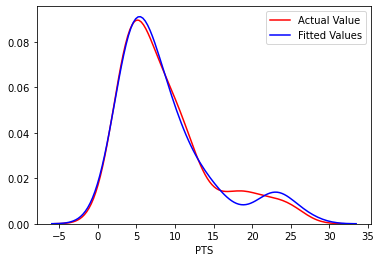

In [237]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(poly_all_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)


In [93]:
np.amin(poly_reg_y_predicted)

0.2496103987488778

Minutes

In [242]:
X = data[['MP']]
Y = data['PTS']

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [244]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

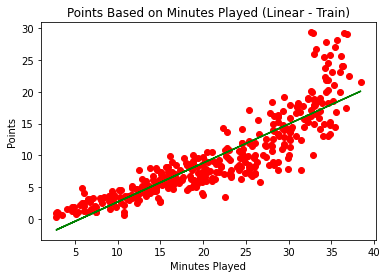

In [245]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, regr.predict(X_train), color = "green")
plt.title("Points Based on Minutes Played (Linear - Train)")
plt.xlabel("Minutes Played")
plt.ylabel("Points")
plt.show()

In [246]:
predictedPoints = regr.predict(X_test)

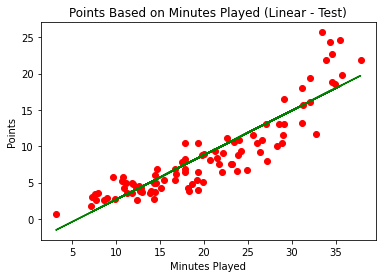

In [247]:
plt.scatter(X_test, y_test, color = "red")
plt.plot(X_test, regr.predict(X_test), color = "green")
plt.title("Points Based on Minutes Played (Linear - Test)")
plt.xlabel("Minutes Played")
plt.ylabel("Points")
plt.show()

In [252]:
lin_min_rmse = np.sqrt(mean_squared_error(y_test, predictedPoints))
print('RMSE:',lin_min_rmse)
print('MSE:',mean_squared_error(y_test, predictedPoints) )

RMSE: 2.57548039735904
MSE: 6.63309927718068


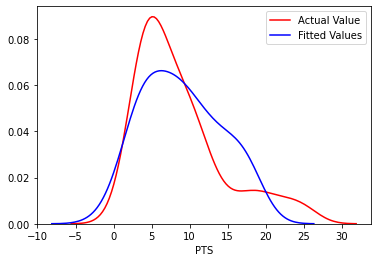

In [249]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(predictedPoints, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [250]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = linear_model.LinearRegression()
pol_reg.fit(X_poly, y_train)

LinearRegression()

In [251]:
poly_min_pred = pol_reg.predict(poly_reg.fit_transform(X_test))

In [254]:
poly_min_rmse = np.sqrt(mean_squared_error(y_test, poly_min_pred))
print('RMSE:',poly_min_rmse)
print('MSE:',mean_squared_error(y_test, poly_min_pred) )

RMSE: 1.9922287276273913
MSE: 3.9689753031838544


In [267]:
X_test.head()

,MP
Rk,
61,10.700
80,17.500
38,14.400
558,14.600
535,34.300


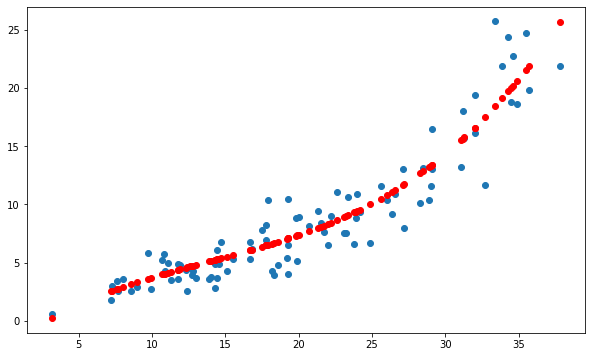

In [271]:
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test)
plt.scatter(X_test, poly_min_pred, c='red')
plt.show()

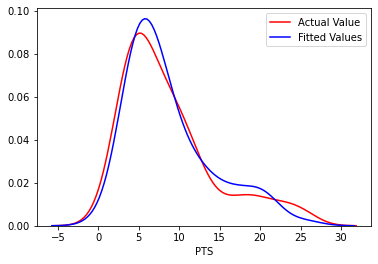

In [255]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(poly_min_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

## ALL STAR

#### Logistic

In [106]:
def class_prediction(predictions_prob, predictions, y_test):
  pred_class_1 = []
  pred_class_2 = []
  for pred in predictions_prob:
    pred_class_1.append(pred[0])
    pred_class_2.append(pred[1])
  pred_dict = {'N_ALL':pred_class_1, 'ALL':pred_class_2, 'Predicted class':predictions, 'Actual class':y_test}
  pred_dict_df = pd.DataFrame(data=pred_dict)
  return pred_dict_df

In [107]:
def print_confusion_matrix(predictions, y_test):
  cf_matrix = metrics.confusion_matrix(y_test, predictions)
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('ALL star based on PTS Confusion Matrix\n\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['Not All Star','All Star'])
  ax.yaxis.set_ticklabels(['Not All Star','All Star'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

Points

In [108]:
X = df[['PTS']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [109]:
logisticRegrPTS = LogisticRegression()
logisticRegrPTS.fit(X_train, y_train)

LogisticRegression()

In [110]:
predictions_prob = logisticRegrPTS.predict_proba(X_test)

In [111]:
predictions = logisticRegrPTS.predict(X_test)

In [112]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,0.999,0.001,0,0
80,0.997,0.003,0,0
38,0.999,0.001,0,0
558,0.999,0.001,0,0
535,0.367,0.633,1,1
279,0.946,0.054,0,0
252,0.980,0.020,0,0
11,0.998,0.002,0,0
444,0.997,0.003,0,0


In [113]:
pd.set_option('display.max_rows', None)

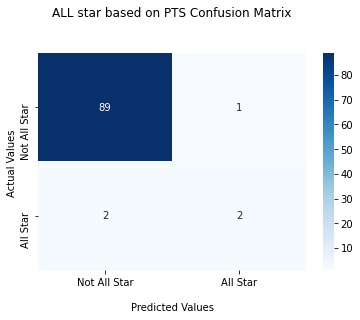

In [114]:
print_confusion_matrix(predictions, y_test)

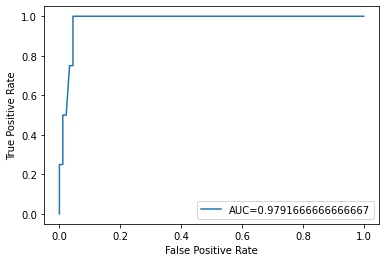

In [115]:
y_pred_proba = logisticRegrPTS.predict_proba(X_test)[::,1]
fprPTS, tprPTS, _ = metrics.roc_curve(y_test,  y_pred_proba)
aucPTS = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fprPTS,tprPTS,label="AUC="+str(aucPTS))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Games

In [116]:
X = df[['G']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [117]:
logisticRegrGS = LogisticRegression()
logisticRegrGS.fit(X_train, y_train)

LogisticRegression()

In [118]:
predictions_prob = logisticRegrGS.predict_proba(X_test)

In [119]:
predictions = logisticRegrGS.predict(X_test)

In [120]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,0.984,0.016,0,0
80,0.994,0.006,0,0
38,0.976,0.024,0,0
558,0.986,0.014,0,0
535,0.892,0.108,0,1
279,0.867,0.133,0,0
252,0.979,0.021,0,0
11,0.925,0.075,0,0
444,0.919,0.081,0,0


In [121]:
pd.set_option('display.max_rows', None)

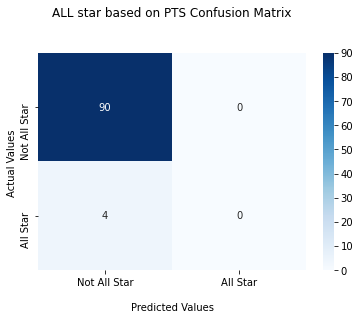

In [122]:
print_confusion_matrix(predictions, y_test)

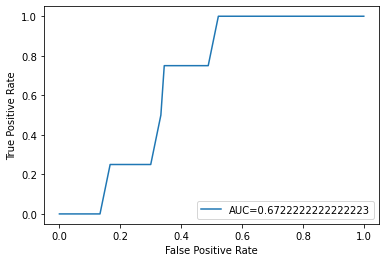

In [123]:
y_pred_proba = logisticRegrGS.predict_proba(X_test)[::,1]
fprGS, tprGS, _ = metrics.roc_curve(y_test,  y_pred_proba)
aucGS = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fprGS,tprGS,label="AUC="+str(aucGS))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Minutes

In [124]:
X = df[['MP']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [125]:
logisticRegrMP = LogisticRegression()
logisticRegrMP.fit(X_train, y_train)

LogisticRegression()

In [126]:
predictions_prob = logisticRegrMP.predict_proba(X_test)

In [127]:
predictions = logisticRegrMP.predict(X_test)

In [128]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,1.000,0.000,0,0
80,1.000,0.000,0,0
38,1.000,0.000,0,0
558,1.000,0.000,0,0
535,0.685,0.315,0,1
279,0.904,0.096,0,0
252,0.965,0.035,0,0
11,0.999,0.001,0,0
444,0.999,0.001,0,0


In [129]:
pd.set_option('display.max_rows', None)

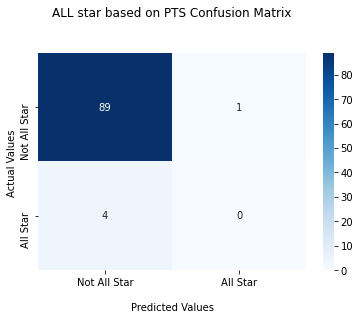

In [130]:
print_confusion_matrix(predictions, y_test)

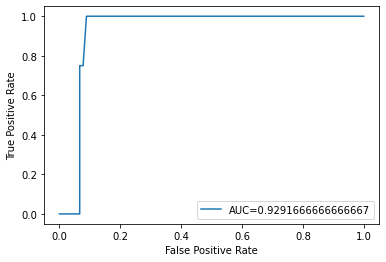

In [131]:
y_pred_proba = logisticRegrMP.predict_proba(X_test)[::,1]
fprMP, tprMP, _ = metrics.roc_curve(y_test,  y_pred_proba)
aucMP = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fprMP,tprMP,label="AUC="+str(aucMP))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

All

In [132]:
X = df[['PTS', 'G', 'MP']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [133]:
logisticRegrALL = LogisticRegression()
logisticRegrALL.fit(X_train, y_train)

LogisticRegression()

In [134]:
predictions_prob = logisticRegrALL.predict_proba(X_test)

In [135]:
predictions = logisticRegrALL.predict(X_test)

In [136]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,1.000,0.000,0,0
80,1.000,0.000,0,0
38,1.000,0.000,0,0
558,1.000,0.000,0,0
535,0.273,0.727,1,1
279,0.912,0.088,0,0
252,0.997,0.003,0,0
11,0.999,0.001,0,0
444,0.999,0.001,0,0


In [137]:
pd.set_option('display.max_rows', None)

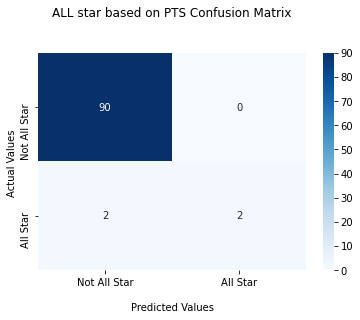

In [138]:
print_confusion_matrix(predictions, y_test)

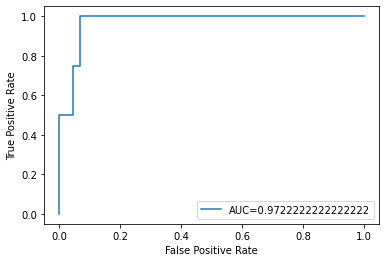

In [139]:
y_pred_proba = logisticRegrALL.predict_proba(X_test)[::,1]
fprALL, tprALL, _ = metrics.roc_curve(y_test,  y_pred_proba)
aucALL = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fprALL,tprALL,label="AUC="+str(aucALL))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

PTS + MP

In [140]:
X = df[['PTS', 'MP']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [141]:
logisticRegrPMP = LogisticRegression()
logisticRegrPMP.fit(X_train, y_train)

LogisticRegression()

In [142]:
predictions_prob = logisticRegrPMP.predict_proba(X_test)

In [143]:
predictions = logisticRegrPMP.predict(X_test)

In [144]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,1.000,0.000,0,0
80,0.999,0.001,0,0
38,1.000,0.000,0,0
558,1.000,0.000,0,0
535,0.399,0.601,1,1
279,0.944,0.056,0,0
252,0.982,0.018,0,0
11,0.999,0.001,0,0
444,0.999,0.001,0,0


In [145]:
pd.set_option('display.max_rows', None)

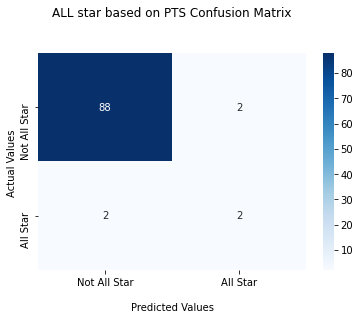

In [146]:
print_confusion_matrix(predictions, y_test)

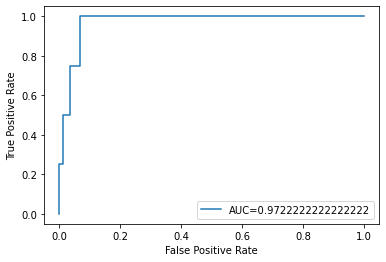

In [147]:
y_pred_proba = logisticRegrPMP.predict_proba(X_test)[::,1]
fprPMP, tprPMP, _ = metrics.roc_curve(y_test,  y_pred_proba)
aucPMP = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fprPMP,tprPMP,label="AUC="+str(aucPMP))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

All logistic curves

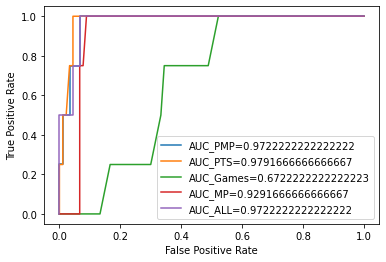

In [148]:
plt.plot(fprPMP,tprPMP,label="AUC_PMP="+str(aucPMP))
plt.plot(fprPTS,tprPTS,label="AUC_PTS="+str(aucPTS))
plt.plot(fprGS,tprGS,label="AUC_Games="+str(aucGS))
plt.plot(fprMP,tprMP,label="AUC_MP="+str(aucMP))
plt.plot(fprALL,tprALL,label="AUC_ALL="+str(aucALL))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#### SVM

In [149]:
kernels = ['linear', 'sigmoid', 'rbf']
target_names = ['N_ALL', 'ALL']

In [150]:
def all_kernels(X_train, y_train, X_test, y_test):
  for krnl in kernels:
    svcclassifier = SVC(kernel=krnl)
    svcclassifier.fit(X_train,y_train)
    predictions = svcclassifier.predict(X_test)
    print('Kernel: ', krnl)
    print(classification_report(y_test, predictions, target_names=target_names))

Points

In [151]:
X = df[['PTS']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [152]:
all_kernels(X_train, y_train, X_test, y_test)

Kernel:  linear
              precision    recall  f1-score   support

       N_ALL       0.98      0.99      0.98        90
         ALL       0.67      0.50      0.57         4

    accuracy                           0.97        94
   macro avg       0.82      0.74      0.78        94
weighted avg       0.96      0.97      0.97        94

Kernel:  sigmoid
              precision    recall  f1-score   support

       N_ALL       0.96      1.00      0.98        90
         ALL       0.00      0.00      0.00         4

    accuracy                           0.96        94
   macro avg       0.48      0.50      0.49        94
weighted avg       0.92      0.96      0.94        94

Kernel:  rbf
              precision    recall  f1-score   support

       N_ALL       0.98      0.99      0.98        90
         ALL       0.67      0.50      0.57         4

    accuracy                           0.97        94
   macro avg       0.82      0.74      0.78        94
weighted avg       0.96     

C:\Users\Vlastnik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


najlepsie RBF

In [153]:
svcclassifierPTS = SVC(kernel='rbf', probability=True)
svcclassifierPTS.fit(X_train,y_train)

SVC(probability=True)

In [154]:
predictions_prob = svcclassifierPTS.predict_proba(X_test)

In [155]:
predictions = svcclassifierPTS.predict(X_test)

In [156]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,0.972,0.028,0,0
80,0.971,0.029,0,0
38,0.974,0.026,0,0
558,0.972,0.028,0,0
535,0.468,0.532,1,1
279,0.971,0.029,0,0
252,0.973,0.027,0,0
11,0.971,0.029,0,0
444,0.971,0.029,0,0


In [157]:
pd.set_option('display.max_rows', None)

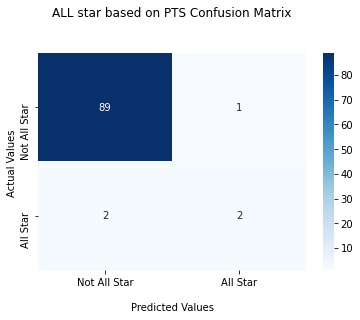

In [158]:
print_confusion_matrix(predictions, y_test)

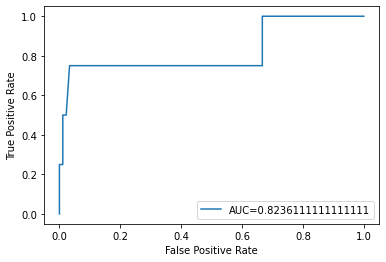

In [159]:
fprPTS_SVM, tprPTS_SVM, _ = metrics.roc_curve(y_test,  predictions_prob[::,1])
aucPTS_SVM = metrics.roc_auc_score(y_test, predictions_prob[::,1])

#create ROC curve
plt.plot(fprPTS_SVM,tprPTS_SVM,label="AUC="+str(aucPTS_SVM))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Games

In [160]:
X = df[['G']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [161]:
all_kernels(X_train, y_train, X_test, y_test)

Kernel:  linear
              precision    recall  f1-score   support

       N_ALL       0.96      1.00      0.98        90
         ALL       0.00      0.00      0.00         4

    accuracy                           0.96        94
   macro avg       0.48      0.50      0.49        94
weighted avg       0.92      0.96      0.94        94

Kernel:  sigmoid
              precision    recall  f1-score   support

       N_ALL       0.96      0.97      0.96        90
         ALL       0.00      0.00      0.00         4

    accuracy                           0.93        94
   macro avg       0.48      0.48      0.48        94
weighted avg       0.92      0.93      0.92        94

Kernel:  rbf
              precision    recall  f1-score   support

       N_ALL       0.96      1.00      0.98        90
         ALL       0.00      0.00      0.00         4

    accuracy                           0.96        94
   macro avg       0.48      0.50      0.49        94
weighted avg       0.92     

C:\Users\Vlastnik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vlastnik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


najlepsie RBF

In [162]:
svcclassifierGS = SVC(kernel='rbf', probability=True)
svcclassifierGS.fit(X_train,y_train)

SVC(probability=True)

In [163]:
predictions_prob = svcclassifierGS.predict_proba(X_test)

In [164]:
predictions = svcclassifierGS.predict(X_test)

In [165]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,0.938,0.062,0,0
80,0.938,0.062,0,0
38,0.938,0.062,0,0
558,0.938,0.062,0,0
535,0.938,0.062,0,1
279,0.938,0.062,0,0
252,0.938,0.062,0,0
11,0.938,0.062,0,0
444,0.938,0.062,0,0


In [166]:
pd.set_option('display.max_rows', None)

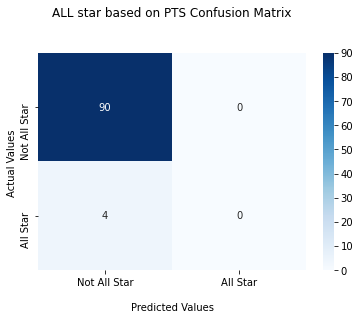

In [167]:
print_confusion_matrix(predictions, y_test)

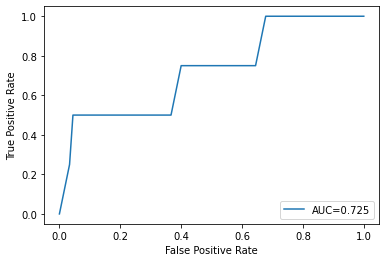

In [168]:
fprGS_SVM, tprGS_SVM, _ = metrics.roc_curve(y_test,  predictions_prob[::,1])
aucGS_SVM = metrics.roc_auc_score(y_test, predictions_prob[::,1])

#create ROC curve
plt.plot(fprGS_SVM,tprGS_SVM,label="AUC="+str(aucGS_SVM))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Minutes

In [169]:
X = df[['MP']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [170]:
all_kernels(X_train, y_train, X_test, y_test)

Kernel:  linear
              precision    recall  f1-score   support

       N_ALL       0.96      1.00      0.98        90
         ALL       0.00      0.00      0.00         4

    accuracy                           0.96        94
   macro avg       0.48      0.50      0.49        94
weighted avg       0.92      0.96      0.94        94

Kernel:  sigmoid
              precision    recall  f1-score   support

       N_ALL       0.96      0.99      0.97        90
         ALL       0.00      0.00      0.00         4

    accuracy                           0.95        94
   macro avg       0.48      0.49      0.49        94
weighted avg       0.92      0.95      0.93        94

Kernel:  rbf
              precision    recall  f1-score   support

       N_ALL       0.96      1.00      0.98        90
         ALL       0.00      0.00      0.00         4

    accuracy                           0.96        94
   macro avg       0.48      0.50      0.49        94
weighted avg       0.92     

C:\Users\Vlastnik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vlastnik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


najlepsie RBF

In [171]:
svcclassifierMP = SVC(kernel='rbf', probability=True)
svcclassifierMP.fit(X_train,y_train)

SVC(probability=True)

In [172]:
predictions_prob = svcclassifierMP.predict_proba(X_test)

In [173]:
predictions = svcclassifierMP.predict(X_test)

In [174]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,0.935,0.065,0,0
80,0.947,0.053,0,0
38,0.937,0.063,0,0
558,0.938,0.062,0,0
535,0.935,0.065,0,1
279,0.935,0.065,0,0
252,0.939,0.061,0,0
11,0.965,0.035,0,0
444,0.964,0.036,0,0


In [175]:
pd.set_option('display.max_rows', None)

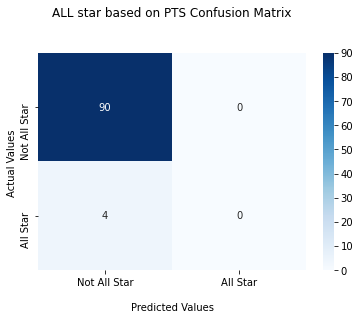

In [176]:
print_confusion_matrix(predictions, y_test)

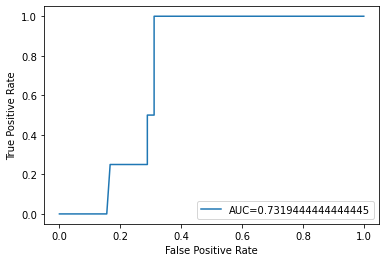

In [177]:
fprMP_SVM, tprMP_SVM, _ = metrics.roc_curve(y_test,  predictions_prob[::,1])
aucMP_SVM = metrics.roc_auc_score(y_test, predictions_prob[::,1])

#create ROC curve
plt.plot(fprMP_SVM,tprMP_SVM,label="AUC="+str(aucMP_SVM))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

ALL

In [178]:
X = df[['PTS','G','MP']]
Y = df['ALLSTAR']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [179]:
all_kernels(X_train, y_train, X_test, y_test)

Kernel:  linear
              precision    recall  f1-score   support

       N_ALL       0.98      1.00      0.99        90
         ALL       1.00      0.50      0.67         4

    accuracy                           0.98        94
   macro avg       0.99      0.75      0.83        94
weighted avg       0.98      0.98      0.98        94

Kernel:  sigmoid
              precision    recall  f1-score   support

       N_ALL       0.96      1.00      0.98        90
         ALL       0.00      0.00      0.00         4

    accuracy                           0.96        94
   macro avg       0.48      0.50      0.49        94
weighted avg       0.92      0.96      0.94        94

Kernel:  rbf
              precision    recall  f1-score   support

       N_ALL       0.98      1.00      0.99        90
         ALL       1.00      0.50      0.67         4

    accuracy                           0.98        94
   macro avg       0.99      0.75      0.83        94
weighted avg       0.98     

C:\Users\Vlastnik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


najlepsie

In [180]:
svcclassifierALL = SVC(kernel='rbf', probability=True)
svcclassifierALL.fit(X_train,y_train)

SVC(probability=True)

In [181]:
predictions_prob = svcclassifierALL.predict_proba(X_test)

In [182]:
predictions = svcclassifierALL.predict(X_test)

In [183]:
class_df = class_prediction(predictions_prob, predictions, y_test)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', None)
class_df

,N_ALL,ALL,Predicted class,Actual class
Rk,,,,
61,0.976,0.024,0,0
80,0.971,0.029,0,0
38,0.988,0.012,0,0
558,0.981,0.019,0,0
535,0.108,0.892,1,1
279,0.967,0.033,0,0
252,0.995,0.005,0,0
11,0.998,0.002,0,0
444,0.998,0.002,0,0


In [184]:
pd.set_option('display.max_rows', None)

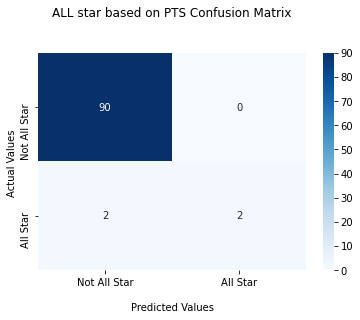

In [185]:
print_confusion_matrix(predictions, y_test)

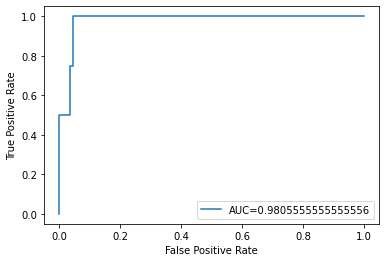

In [186]:
fprALL_SVM, tprALL_SVM, _ = metrics.roc_curve(y_test,  predictions_prob[::,1])
aucALL_SVM = metrics.roc_auc_score(y_test, predictions_prob[::,1])

#create ROC curve
plt.plot(fprALL_SVM,tprALL_SVM,label="AUC="+str(aucALL_SVM))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

All SVM curves

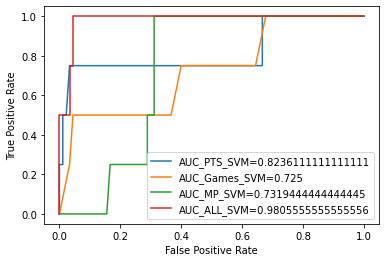

In [187]:
plt.plot(fprPTS_SVM,tprPTS_SVM,label="AUC_PTS_SVM="+str(aucPTS_SVM))
plt.plot(fprGS_SVM,tprGS_SVM,label="AUC_Games_SVM="+str(aucGS_SVM))
plt.plot(fprMP_SVM,tprMP_SVM,label="AUC_MP_SVM="+str(aucMP_SVM))
plt.plot(fprALL_SVM,tprALL_SVM,label="AUC_ALL_SVM="+str(aucALL_SVM))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

All curves

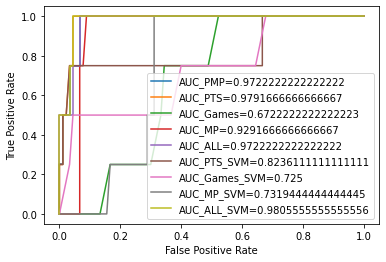

In [188]:
plt.plot(fprPMP,tprPMP,label="AUC_PMP="+str(aucPMP))
plt.plot(fprPTS,tprPTS,label="AUC_PTS="+str(aucPTS))
plt.plot(fprGS,tprGS,label="AUC_Games="+str(aucGS))
plt.plot(fprMP,tprMP,label="AUC_MP="+str(aucMP))
plt.plot(fprALL,tprALL,label="AUC_ALL="+str(aucALL))
plt.plot(fprPTS_SVM,tprPTS_SVM,label="AUC_PTS_SVM="+str(aucPTS_SVM))
plt.plot(fprGS_SVM,tprGS_SVM,label="AUC_Games_SVM="+str(aucGS_SVM))
plt.plot(fprMP_SVM,tprMP_SVM,label="AUC_MP_SVM="+str(aucMP_SVM))
plt.plot(fprALL_SVM,tprALL_SVM,label="AUC_ALL_SVM="+str(aucALL_SVM))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()